In [1]:
import pandas as pd
import numpy as np
import re
import os
from sklearn.model_selection import train_test_split

# Paths to datasets
data_path = '/kaggle/input/train-dataset-trans-learn'
files = ['train_en_l1.csv', 'train_hi_l1.csv', 'train_ta_l1.csv']

# Function to load datasets with language info
def load_data(files, data_path):
    dfs = []
    for file in files:
        lang = file.split('_')[1] 
        df = pd.read_csv(os.path.join(data_path, file))
        df['language'] = lang
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load all datasets
df = load_data(files, data_path)

# Drop rows where label is still missing
df.dropna(subset=['label'], inplace=True)

# Step 3: Enhanced Text Cleaning
def clean_text(text):
    text = text.lower()  # Lowercase the text

    # Preserve hashtags and mentions
    text = re.sub(r'@\w+', '[USER]', text)  # Replace handles with [USER]
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs with [URL]

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Keep alphanumeric (English, Hindi, Tamil) + hashtags and mentions
    text = re.sub(r'[^a-zA-Z0-9#@ऀ-ॿ஀-௿\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Step 4: Finalize Dataset
df_final = df[['cleaned_text', 'label', 'language']]

# Save cleaned dataset
df_final.to_csv('cleaned_l1.csv', index=False)

print("Data preparation complete! Cleaned dataset saved as 'cleaned_l1.csv'.")

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])

print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")

Data preparation complete! Cleaned dataset saved as 'cleaned_l1.csv'.
Training set: 44946 samples
Validation set: 11237 samples


In [33]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, DataCollatorWithPadding

class GenderedAbuseDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
    
        encoding = self.tokenizer(
            text,
            max_length=self.max_length,
            padding='max_length',   # make sure all inputs in a batch are same length
            truncation=True,
            return_tensors='pt'     # important: directly get torch tensors
        )
    
        return {
            'input_ids': encoding['input_ids'].squeeze(0),       
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'label': torch.tensor(label, dtype=torch.float)
        }


# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

# Create datasets
train_dataset = GenderedAbuseDataset(
    train_df['cleaned_text'].tolist(),
    train_df['label'].tolist(),
    tokenizer
)

val_dataset = GenderedAbuseDataset(
    val_df['cleaned_text'].tolist(),
    val_df['label'].tolist(),
    tokenizer
)

# dynamic padding
data_collator = DataCollatorWithPadding(
    tokenizer=tokenizer,
    padding='longest', 
    return_tensors='pt'
)

# Create dataloaders with the data collator
batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=data_collator)

GRU + SELF ATTENTION WITH RESTRICTED WINDOW SIZE

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import BertModel

class BERTGRUAttention(nn.Module):
    def __init__(self, bert_model_name='bert-base-multilingual-cased', hidden_dim=256, 
                 n_layers=2, dropout=0.3, window_size=5):
        super().__init__()
        
        # BERT for embeddings
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.embedding_dim = self.bert.config.hidden_size
        
        for param in self.bert.parameters():
            param.requires_grad = False
            
        # GRU layer
        self.gru = nn.GRU(self.embedding_dim, 
                          hidden_dim, 
                          num_layers=n_layers, 
                          bidirectional=True, 
                          batch_first=True,
                          dropout=dropout if n_layers > 1 else 0)
        
        # Self-attention with restricted context window
        self.window_size = window_size
        self.attention_weights = nn.Linear(hidden_dim * 2, 1)
        
        # Final classification layers
        self.fc1 = nn.Linear(hidden_dim * 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)
        self.dropout = nn.Dropout(dropout)
        
    def attention_net(self, gru_output, attention_mask):
        batch_size, seq_len, hidden_dim = gru_output.shape
        
        # Calculate attention scores
        attention_scores = self.attention_weights(gru_output).squeeze(-1) 
        
        # Apply padding mask first (set padding positions to -inf before softmax)
        attention_scores = attention_scores.masked_fill(attention_mask == 0, -1e10)
        
        # Create window mask for each position
        windowed_attention = torch.zeros_like(attention_scores)
        
        for i in range(seq_len):
            # Define window boundaries
            start = max(0, i - self.window_size)
            end = min(seq_len, i + self.window_size + 1)
            
            # Extract scores for current window
            window_scores = attention_scores[:, start:end]
            
            # Apply softmax within the window
            window_weights = F.softmax(window_scores, dim=1)  # [batch_size, window_size*2]
            
            # Create a weighted sum of the GRU outputs within the window
            context_vectors = torch.bmm(
                window_weights.unsqueeze(1),  # [batch_size, 1, window_size*2]
                gru_output[:, start:end, :]   # [batch_size, window_size*2, hidden_dim*2]
            )  # Result: [batch_size, 1, hidden_dim*2]
            
            # Store the context vector for this position
            if i == 0:
                context = context_vectors
            else:
                context = torch.cat((context, context_vectors), dim=1)
        
        # Get the mean of all non-padded positions
        mask_expanded = attention_mask.unsqueeze(-1).expand(-1, -1, hidden_dim)
        masked_context = context * mask_expanded
        sum_context = torch.sum(masked_context, dim=1)
        sum_mask = torch.sum(attention_mask, dim=1, keepdim=True).expand(-1, hidden_dim)
        output = sum_context / (sum_mask + 1e-9)  # Avoid division by zero
        
        return output
        
    def forward(self, input_ids, attention_mask):
        # Get BERT embeddings
        with torch.no_grad():
            bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        embedded = bert_output.last_hidden_state
        
        # Apply GRU
        gru_output, _ = self.gru(embedded)
        
        # Apply attention
        attention_output = self.attention_net(gru_output, attention_mask)
        
        # Final classification
        output = self.dropout(F.relu(self.fc1(attention_output)))  # shape: [batch_size, hidden_dim]
        output = self.fc2(output)  # shape: [batch_size, 1]
    
        return torch.sigmoid(output).squeeze(-1)

Training Function

In [4]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

def train_model(model, train_loader, val_loader, criterion, optimizer, device, epochs=10):
    best_val_macro_f1 = 0.0
    history = {'train_loss': [], 'val_loss': [], 'val_accuracy': [], 'val_f1': [], 
               'val_macro_f1': [], 'val_auc': []}
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_losses = []
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}')
        
        for batch in pbar:
            # Get batch data
            # print(batch)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].float().to(device)  # Ensure labels are float
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask)
            
            # Handle potential shape mismatch
            if outputs.shape != labels.shape:
                if outputs.dim() > 1 and outputs.shape[1] == 128:  # If second dimension is sequence length
                    # Option 1: Take the output of the first token (like BERT's [CLS])
                    outputs = outputs[:, 0]
                    # Option 2: Or take the mean across sequence dimension
                    # outputs = outputs.mean(dim=1)
            
            loss = criterion(outputs, labels)
            
            # Backward pass
            loss.backward()
            optimizer.step()
            
            train_losses.append(loss.item())
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        avg_train_loss = sum(train_losses) / len(train_losses)
        history['train_loss'].append(avg_train_loss)
        
        # Validation
        model.eval()
        val_losses = []
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].float().to(device)
                
                outputs = model(input_ids, attention_mask)
                
                # Handle potential shape mismatch (same as in training)
                if outputs.shape != labels.shape:
                    if outputs.dim() > 1 and outputs.shape[1] == 128:
                        outputs = outputs[:, 0]
                
                loss = criterion(outputs, labels)
                
                val_losses.append(loss.item())
                val_preds.extend(outputs.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        
        # Calculate metrics
        val_preds_binary = np.array(val_preds) >= 0.5
        val_labels = np.array(val_labels)
    
        accuracy = accuracy_score(val_labels, val_preds_binary)
        precision, recall, f1, _ = precision_recall_fscore_support(
            val_labels, val_preds_binary, average='binary'
        )
        macro_f1 = f1_score(val_labels, val_preds_binary, average='macro')
        auc = roc_auc_score(val_labels, val_preds)
    
        avg_val_loss = sum(val_losses) / len(val_losses)
        history['val_loss'].append(avg_val_loss)
        history['val_accuracy'].append(accuracy)
        history['val_f1'].append(f1)
        history['val_macro_f1'].append(macro_f1)
        history['val_auc'].append(auc)
    
        print(f'\nEpoch {epoch+1}/{epochs}:')
        print(f'Train Loss: {avg_train_loss:.4f}')
        print(f'Val Loss: {avg_val_loss:.4f}, Accuracy: {accuracy:.4f}, F1: {f1:.4f}')
        print(f'Macro F1: {macro_f1:.4f}, AUC: {auc:.4f}')
    
        # Save best model based on macro F1
        if macro_f1 > best_val_macro_f1:
            best_val_macro_f1 = macro_f1
            torch.save(model.state_dict(), 'best_model.pt')
            print(f'Model saved with Macro F1: {macro_f1:.4f}')
    
    return history

Model Training

In [5]:
# _______________________________
#      MODEL TRAINING 
# _______________________________

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize model
model = BERTGRUAttention(
    bert_model_name='bert-base-multilingual-cased',
    hidden_dim=256,
    n_layers=2,
    dropout=0.3,
    window_size=5
)
model.to(device)

# Set up loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.AdamW([
    {'params': model.gru.parameters()},
    {'params': model.attention_weights.parameters()},
    {'params': model.fc1.parameters()},
    {'params': model.fc2.parameters()}
], lr=2e-4)

# Train the model
history = train_model(
    model, 
    train_loader, 
    val_loader, 
    criterion, 
    optimizer, 
    device, 
    epochs=5
)

Using device: cuda


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Epoch 1/5: 100%|██████████| 2810/2810 [05:07<00:00,  9.13it/s, loss=0.0928]



Epoch 1/5:
Train Loss: 0.4566
Val Loss: 0.4120, Accuracy: 0.7944, F1: 0.8109
Macro F1: 0.7929, AUC: 0.8937
Model saved with Macro F1: 0.7929


Epoch 2/5: 100%|██████████| 2810/2810 [05:07<00:00,  9.13it/s, loss=0.0833]



Epoch 2/5:
Train Loss: 0.3823
Val Loss: 0.3439, Accuracy: 0.8341, F1: 0.8665
Macro F1: 0.8237, AUC: 0.9243
Model saved with Macro F1: 0.8237


Epoch 3/5: 100%|██████████| 2810/2810 [05:08<00:00,  9.11it/s, loss=0.6636]



Epoch 3/5:
Train Loss: 0.3447
Val Loss: 0.3166, Accuracy: 0.8515, F1: 0.8721
Macro F1: 0.8475, AUC: 0.9347
Model saved with Macro F1: 0.8475


Epoch 4/5: 100%|██████████| 2810/2810 [05:08<00:00,  9.12it/s, loss=0.1255]



Epoch 4/5:
Train Loss: 0.3181
Val Loss: 0.3141, Accuracy: 0.8549, F1: 0.8815
Macro F1: 0.8471, AUC: 0.9399


Epoch 5/5: 100%|██████████| 2810/2810 [05:07<00:00,  9.15it/s, loss=0.0480]



Epoch 5/5:
Train Loss: 0.2968
Val Loss: 0.3090, Accuracy: 0.8625, F1: 0.8859
Macro F1: 0.8565, AUC: 0.9420
Model saved with Macro F1: 0.8565


Preparing the test dataset for evaluation

In [28]:
# Paths to datasets
data_path = '/kaggle/input/test-dataset-trans-learn'
files = ['test_en_l1.csv', 'test_hi_l1.csv', 'test_ta_l1.csv']

# Function to load datasets with language info
def load_data(files, data_path):
    dfs = []
    for file in files:
        lang = file.split('_')[1] 
        df = pd.read_csv(os.path.join(data_path, file))
        df['language'] = lang
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load all datasets
df = load_data(files, data_path)

# Drop rows where label is still missing
df.dropna(subset=['label'], inplace=True)

# Step 3: Enhanced Text Cleaning
def clean_text(text):
    text = text.lower()  # Lowercase the text

    # Preserve hashtags and mentions
    text = re.sub(r'@\w+', '[USER]', text)  # Replace handles with [USER]
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs with [URL]

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Keep alphanumeric (English, Hindi, Tamil) + hashtags and mentions
    text = re.sub(r'[^a-zA-Z0-9#@ऀ-ॿ஀-௿\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Step 4: Finalize Dataset
df_final = df[['cleaned_text', 'label', 'language']]

# Save cleaned dataset
df_final.to_csv('cleaned_test.csv', index=False)

print("Data preparation complete! Cleaned dataset saved as 'cleaned_test.csv'.")

Data preparation complete! Cleaned dataset saved as 'cleaned_test.csv'.


Evaluation with Macro F1 and Loss Plotting

/tmp/ipykernel_31/76668940.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))


Macro F1 Score on test set: 0.8603

Classification Report:
              precision    recall  f1-score   support

         0.0       0.84      0.82      0.83      7568
         1.0       0.89      0.90      0.89     11943

    accuracy                           0.87     19511
   macro avg       0.86      0.86      0.86     19511
weighted avg       0.87      0.87      0.87     19511



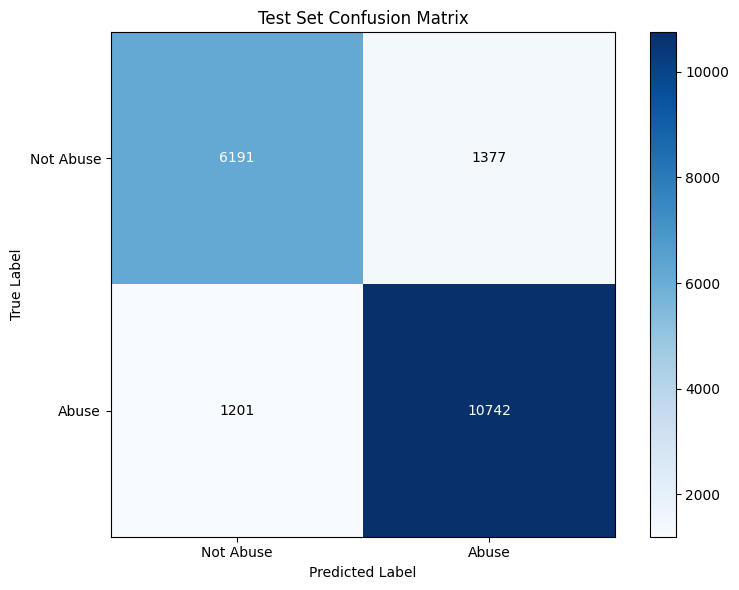

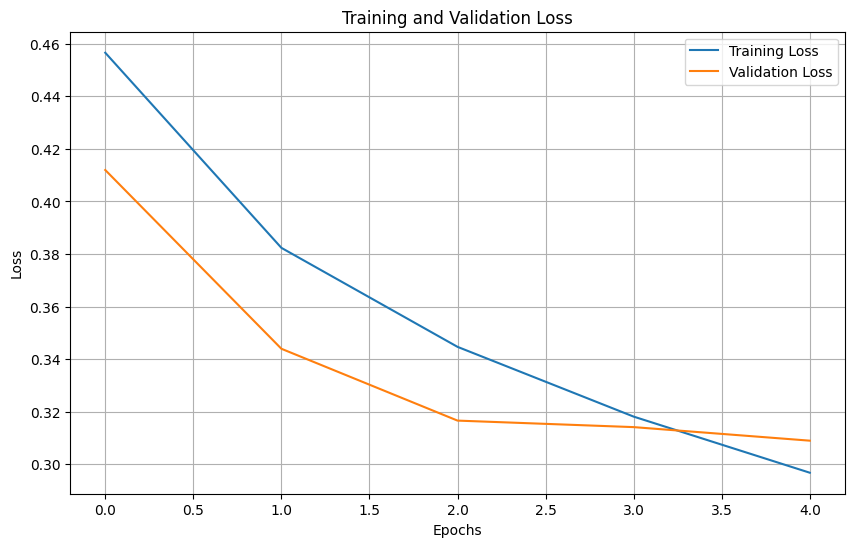

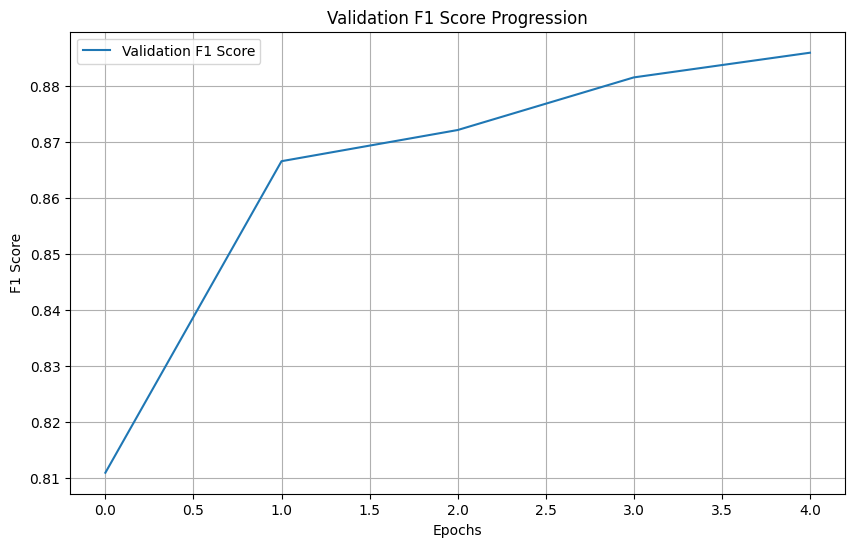

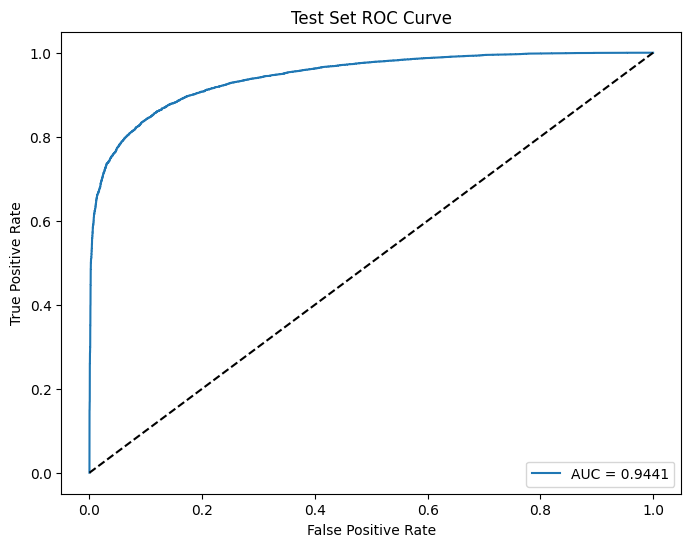

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, f1_score
from torch.utils.data import DataLoader, Dataset

# Load test data
test_data = pd.read_csv('cleaned_test.csv')

test_dataset = GenderedAbuseDataset(
    texts=test_data['cleaned_text'].values,
    labels=test_data['label'].values, 
    tokenizer=tokenizer,
    max_length=128
)

test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load best model
model.load_state_dict(torch.load('best_model.pt'))
model.to(device)
model.eval()

# Evaluate on test set
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label']  
        
        outputs = model(input_ids, attention_mask)
        
        # Handle the shape mismatch if needed
        if outputs.dim() > 1 and outputs.shape[1] == 128:
            # Take first token or mean across sequence
            outputs = outputs[:, 0]
            # Alternative: outputs = outputs.mean(dim=1)
        
        test_preds.extend(outputs.cpu().numpy())
        test_labels.extend(labels.numpy())

# Convert predictions to binary
test_preds_binary = np.array(test_preds) >= 0.5
test_labels = np.array(test_labels)

# Calculate macro F1 score
macro_f1 = f1_score(test_labels, test_preds_binary, average='macro')
print(f"Macro F1 Score on test set: {macro_f1:.4f}")

# Print full classification report (includes precision, recall, and F1 for each class)
print("\nClassification Report:")
print(classification_report(test_labels, test_preds_binary))

# Plot confusion matrix
cm = confusion_matrix(test_labels, test_preds_binary)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Test Set Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not Abuse', 'Abuse'])
plt.yticks(tick_marks, ['Not Abuse', 'Abuse'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Add text annotations
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, format(cm[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")
plt.tight_layout()
plt.savefig('test_confusion_matrix.png')
plt.show()

# Plot training and validation loss (keeping this unchanged)
plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_curves.png')
plt.show()

# Plot F1 score progression (keeping this unchanged)
plt.figure(figsize=(10, 6))
plt.plot(history['val_f1'], label='Validation F1 Score')
plt.title('Validation F1 Score Progression')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('f1_progression.png')
plt.show()

# ROC curve for test data
fpr, tpr, _ = roc_curve(test_labels, test_preds)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc_score(test_labels, test_preds):.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Test Set ROC Curve')
plt.legend(loc='lower right')
plt.savefig('test_roc_curve.png')
plt.show()

TRANSFER LEARNING - FINE TUNING

Class distribution:
label
0.0    0.687343
1.0    0.312657
Name: proportion, dtype: float64
Class weights: {0: 0.7274388424821002, 1: 1.5991965896048532}


/tmp/ipykernel_31/1193273319.py:59: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pt'))
Fine-tuning epoch 1: 100%|██████████| 97

Epoch 1 - Training loss: 0.9043


Validation epoch 1: 100%|██████████| 244/244 [00:18<00:00, 13.29it/s]


Optimal threshold for epoch 1: 0.5500
Epoch 1 - Validation loss: 0.8811, Macro F1: 0.6960
Precision: 0.6926, Recall: 0.7007

Sample predictions:
True: 0.0, Pred prob: 0.5017, Pred: False, Threshold: 0.5500
True: 0.0, Pred prob: 0.5382, Pred: False, Threshold: 0.5500
True: 1.0, Pred prob: 0.6356, Pred: True, Threshold: 0.5500
True: 0.0, Pred prob: 0.5087, Pred: False, Threshold: 0.5500
True: 1.0, Pred prob: 0.7306, Pred: True, Threshold: 0.5500
Saved new best fine-tuned model with Macro F1: 0.6960


Fine-tuning epoch 2: 100%|██████████| 976/976 [01:57<00:00,  8.34it/s]


Epoch 2 - Training loss: 0.8816


Validation epoch 2: 100%|██████████| 244/244 [00:18<00:00, 13.34it/s]


Optimal threshold for epoch 2: 0.5500
Epoch 2 - Validation loss: 0.8764, Macro F1: 0.6981
Precision: 0.7026, Recall: 0.6945
Saved new best fine-tuned model with Macro F1: 0.6981


Fine-tuning epoch 3: 100%|██████████| 976/976 [01:57<00:00,  8.33it/s]


Epoch 3 - Training loss: 0.8768


Validation epoch 3: 100%|██████████| 244/244 [00:18<00:00, 13.25it/s]


Optimal threshold for epoch 3: 0.5500
Epoch 3 - Validation loss: 0.8727, Macro F1: 0.7071
Precision: 0.7072, Recall: 0.7070

Sample predictions:
True: 0.0, Pred prob: 0.5001, Pred: False, Threshold: 0.5500
True: 1.0, Pred prob: 0.5000, Pred: False, Threshold: 0.5500
True: 0.0, Pred prob: 0.5000, Pred: False, Threshold: 0.5500
True: 1.0, Pred prob: 0.6219, Pred: True, Threshold: 0.5500
True: 0.0, Pred prob: 0.5000, Pred: False, Threshold: 0.5500
Saved new best fine-tuned model with Macro F1: 0.7071


Fine-tuning epoch 4: 100%|██████████| 976/976 [01:56<00:00,  8.36it/s]


Epoch 4 - Training loss: 0.8738


Validation epoch 4: 100%|██████████| 244/244 [00:18<00:00, 13.26it/s]


Optimal threshold for epoch 4: 0.5500
Epoch 4 - Validation loss: 0.8695, Macro F1: 0.7166
Precision: 0.7128, Recall: 0.7216
Saved new best fine-tuned model with Macro F1: 0.7166


Fine-tuning epoch 5: 100%|██████████| 976/976 [01:56<00:00,  8.35it/s]


Epoch 5 - Training loss: 0.8691


Validation epoch 5: 100%|██████████| 244/244 [00:18<00:00, 13.26it/s]


Optimal threshold for epoch 5: 0.5500
Epoch 5 - Validation loss: 0.8688, Macro F1: 0.7148
Precision: 0.7139, Recall: 0.7158

Sample predictions:
True: 0.0, Pred prob: 0.5005, Pred: False, Threshold: 0.5500
True: 1.0, Pred prob: 0.7310, Pred: True, Threshold: 0.5500
True: 0.0, Pred prob: 0.5000, Pred: False, Threshold: 0.5500
True: 1.0, Pred prob: 0.5000, Pred: False, Threshold: 0.5500
True: 0.0, Pred prob: 0.7310, Pred: True, Threshold: 0.5500


Fine-tuning epoch 6: 100%|██████████| 976/976 [01:57<00:00,  8.33it/s]


Epoch 6 - Training loss: 0.8671


Validation epoch 6: 100%|██████████| 244/244 [00:18<00:00, 13.31it/s]


Optimal threshold for epoch 6: 0.5500
Epoch 6 - Validation loss: 0.8678, Macro F1: 0.7163
Precision: 0.7136, Recall: 0.7196


Fine-tuning epoch 7: 100%|██████████| 976/976 [01:56<00:00,  8.35it/s]


Epoch 7 - Training loss: 0.8649


Validation epoch 7: 100%|██████████| 244/244 [00:18<00:00, 13.32it/s]


Optimal threshold for epoch 7: 0.5500
Epoch 7 - Validation loss: 0.8674, Macro F1: 0.7146
Precision: 0.7140, Recall: 0.7151

Sample predictions:
True: 0.0, Pred prob: 0.5000, Pred: False, Threshold: 0.5500
True: 1.0, Pred prob: 0.7308, Pred: True, Threshold: 0.5500
True: 0.0, Pred prob: 0.5002, Pred: False, Threshold: 0.5500
True: 0.0, Pred prob: 0.5002, Pred: False, Threshold: 0.5500
True: 0.0, Pred prob: 0.7307, Pred: True, Threshold: 0.5500


Fine-tuning epoch 8: 100%|██████████| 976/976 [01:56<00:00,  8.35it/s]


Epoch 8 - Training loss: 0.8640


Validation epoch 8: 100%|██████████| 244/244 [00:18<00:00, 13.34it/s]


Optimal threshold for epoch 8: 0.5500
Epoch 8 - Validation loss: 0.8670, Macro F1: 0.7146
Precision: 0.7154, Recall: 0.7138


Fine-tuning epoch 9: 100%|██████████| 976/976 [01:56<00:00,  8.37it/s]


Epoch 9 - Training loss: 0.8652


Validation epoch 9: 100%|██████████| 244/244 [00:18<00:00, 13.33it/s]


Optimal threshold for epoch 9: 0.5500
Epoch 9 - Validation loss: 0.8670, Macro F1: 0.7149
Precision: 0.7135, Recall: 0.7164

Sample predictions:
True: 0.0, Pred prob: 0.5012, Pred: False, Threshold: 0.5500
True: 0.0, Pred prob: 0.7310, Pred: True, Threshold: 0.5500
True: 0.0, Pred prob: 0.5449, Pred: False, Threshold: 0.5500
True: 0.0, Pred prob: 0.5000, Pred: False, Threshold: 0.5500
True: 0.0, Pred prob: 0.5000, Pred: False, Threshold: 0.5500


Fine-tuning epoch 10: 100%|██████████| 976/976 [01:56<00:00,  8.36it/s]


Epoch 10 - Training loss: 0.8638


Validation epoch 10: 100%|██████████| 244/244 [00:18<00:00, 13.25it/s]


Optimal threshold for epoch 10: 0.5500
Epoch 10 - Validation loss: 0.8670, Macro F1: 0.7148
Precision: 0.7130, Recall: 0.7167
Fine-tuning complete! Loading best model for evaluation...


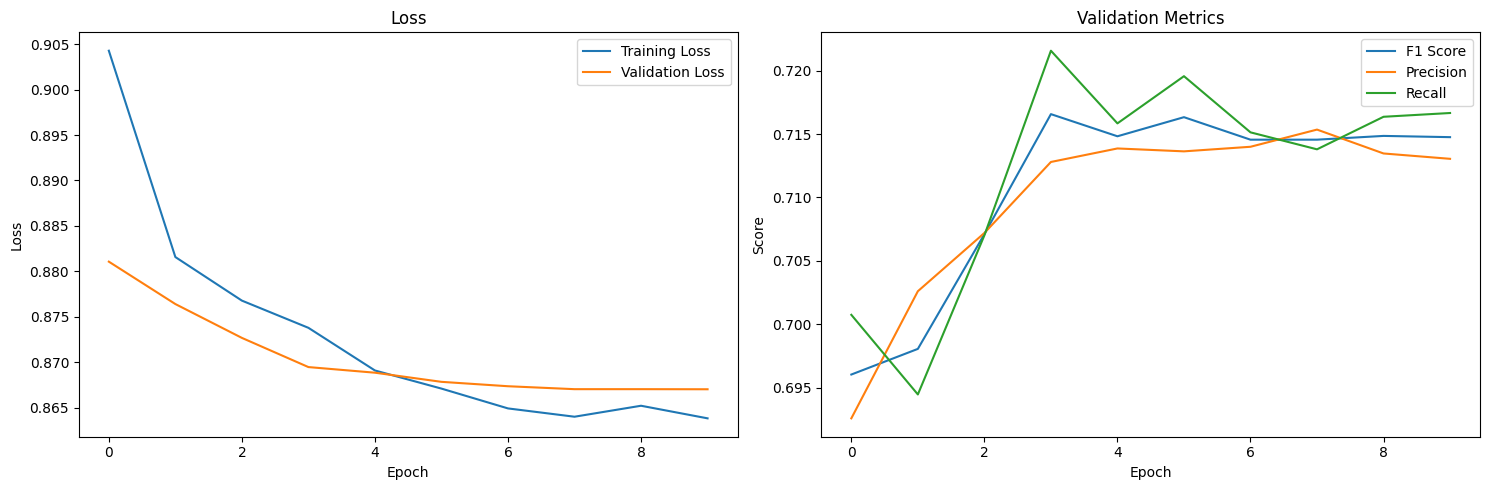

In [ ]:
from torch.optim import Adam
from transformers import get_cosine_schedule_with_warmup
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score
from tqdm import tqdm
import matplotlib.pyplot as plt

# Load your new dataset
new_data = pd.read_csv('/kaggle/input/transfer-learn-test/cleaned_dataset_l1.csv')  # Replace with your new dataset path

# Check class distribution
print("Class distribution:")
print(new_data['label'].value_counts(normalize=True))

# Handle class imbalance - compute class weights
class_counts = new_data['label'].value_counts()
total_samples = len(new_data)
class_weights = {
    0: total_samples / (2 * class_counts[0]) if 0 in class_counts else 1.0,
    1: total_samples / (2 * class_counts[1]) if 1 in class_counts else 1.0
}
print(f"Class weights: {class_weights}")

train_data, val_data = train_test_split(new_data, test_size=0.2, random_state=42, stratify=new_data['label'])

train_dataset = GenderedAbuseDataset(
    texts=train_data['cleaned_text'].values,
    labels=train_data['label'].values, 
    tokenizer=tokenizer,
    max_length=128
)

val_dataset = GenderedAbuseDataset(
    texts=val_data['cleaned_text'].values,
    labels=val_data['label'].values,
    tokenizer=tokenizer,
    max_length=128
)

# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False
)

# Load your pre-trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load('best_model_transfer_learning.pt'))
model.to(device)

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Optimizer with higher learning rates
optimizer = Adam([
    {'params': [p for n, p in model.named_parameters() if 'classifier' not in n], 'lr': 3e-5},  # Higher LR for base model
    {'params': [p for n, p in model.named_parameters() if 'classifier' in n], 'lr': 1e-4}  # Higher LR for classifier
])

num_epochs = 10
total_steps = len(train_loader) * num_epochs

# Create cosine learning rate scheduler with warmup
scheduler = get_cosine_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(0.1 * total_steps),  # 10% of total steps for warmup
    num_training_steps=total_steps
)

# Define weighted loss function for class imbalance
def weighted_bce_loss(outputs, labels, pos_weight):
    loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    return loss_fn(outputs, labels)

# Fine-tuning loop
history = {
    'train_loss': [], 
    'val_loss': [], 
    'val_f1': [],
    'val_precision': [],
    'val_recall': []
}
best_val_macro_f1 = 0

# Calculate positive weight for loss function
pos_weight = torch.tensor([class_weights[1] / class_weights[0]]).to(device)

# Function to find optimal threshold
def find_optimal_threshold(true_labels, pred_probs):
    best_f1 = 0
    best_threshold = 0.5
    for threshold in np.arange(0.3, 0.7, 0.05):
        preds = pred_probs >= threshold
        f1 = f1_score(true_labels, preds, average='macro')
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    return best_threshold

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    
    for batch in tqdm(train_loader, desc=f"Fine-tuning epoch {epoch+1}"):
        model.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        if logits.dim() > 1 and logits.shape[1] > 1:
            logits = logits.squeeze(-1)
            
        # Use weighted loss
        loss = weighted_bce_loss(logits, labels, pos_weight)
        
        total_train_loss += loss.item()
        
        # Backward pass
        loss.backward()
        
        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        # Print gradient norms periodically to debug
        if batch == train_loader.dataset.__len__() - 1 and epoch % 2 == 0:
            for name, param in model.named_parameters():
                if param.grad is not None:
                    print(f"Gradient norm for {name}: {param.grad.norm().item()}")
        
        # Update parameters
        optimizer.step()
        scheduler.step()
    
    avg_train_loss = total_train_loss / len(train_loader)
    history['train_loss'].append(avg_train_loss)
    print(f"Epoch {epoch+1} - Training loss: {avg_train_loss:.4f}")
    
    # Validation phase
    model.eval()
    val_preds = []
    val_labels = []
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Validation epoch {epoch+1}"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label']
            
            # Forward pass
            outputs = model(input_ids, attention_mask=attention_mask)
            
            # Get logits
            logits = outputs.logits if hasattr(outputs, 'logits') else outputs
            
            if logits.dim() > 1 and logits.shape[1] > 1:
                logits = logits.squeeze(-1)
            
            # Calculate loss
            val_loss = weighted_bce_loss(logits, labels.to(device), pos_weight)
            total_val_loss += val_loss.item()
            
            # Get predictions
            preds = torch.sigmoid(logits).cpu().numpy()
            val_preds.extend(preds.flatten())
            val_labels.extend(labels.numpy())
    
    # Find optimal threshold
    optimal_threshold = find_optimal_threshold(np.array(val_labels), np.array(val_preds))
    print(f"Optimal threshold for epoch {epoch+1}: {optimal_threshold:.4f}")
    
    # Convert predictions to binary using optimal threshold
    val_preds_binary = np.array(val_preds) >= optimal_threshold
    val_true = np.array(val_labels)
    
    # Calculate metrics
    macro_f1 = f1_score(val_true, val_preds_binary, average='macro')
    precision = precision_score(val_true, val_preds_binary, average='macro')
    recall = recall_score(val_true, val_preds_binary, average='macro')
    
    avg_val_loss = total_val_loss / len(val_loader)
    history['val_loss'].append(avg_val_loss)
    history['val_f1'].append(macro_f1)
    history['val_precision'].append(precision)
    history['val_recall'].append(recall)
    
    print(f"Epoch {epoch+1} - Validation loss: {avg_val_loss:.4f}, Macro F1: {macro_f1:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")
    
    # Sample predictions to verify changes
    if epoch % 2 == 0:
        print("\nSample predictions:")
        sample_indices = np.random.choice(len(val_preds), min(5, len(val_preds)), replace=False)
        for idx in sample_indices:
            print(f"True: {val_true[idx]}, Pred prob: {val_preds[idx]:.4f}, Pred: {val_preds_binary[idx]}, Threshold: {optimal_threshold:.4f}")
    
    # Save the best model
    if macro_f1 > best_val_macro_f1:
        best_val_macro_f1 = macro_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'threshold': optimal_threshold,
            'macro_f1': macro_f1
        }, 'best_model_fine_tuned.pt')
        print(f"Saved new best fine-tuned model with Macro F1: {macro_f1:.4f}")

print("Fine-tuning complete! Loading best model for evaluation...")

# Plot the training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='F1 Score')
plt.plot(history['val_precision'], label='Precision')
plt.plot(history['val_recall'], label='Recall')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()

In [29]:
# Paths to datasets
data_path = '/kaggle/input/fine-tuned-test-dataset'
files = ['test_en_l1.csv', 'test_hi_l1.csv','test_ta_l1.csv']

# Function to load datasets with language info
def load_data(files, data_path):
    dfs = []
    for file in files:
        lang = file.split('_')[1]
        file_path = os.path.join(data_path, file)
        try:
            # Try with 'c' engine (faster)
            # "engine": "python", "on_bad_lines": "warn"
            df = pd.read_csv(file_path, engine='python', encoding='utf-8', on_bad_lines='warn')
        except Exception as e:
            print(f"Failed with 'c' engine for {file}: {e}, trying 'python' engine...")
            try:
                df = pd.read_csv(file_path, engine='python', encoding='utf-8', error_bad_lines=False)
            except Exception as e2:
                print(f"Skipping {file} due to read error: {e2}")
                continue

        df['language'] = lang
        dfs.append(df)
    return pd.concat(dfs, ignore_index=True)

# Load all datasets
df = load_data(files, data_path)

# Step 1: Handle Missing Values
def clean_missing_values(df):
    # Replace 'NL' with np.nan for easier handling
    df.replace('NL', np.nan, inplace=True)

    # Drop rows where all annotations are missing
    annotator_cols = [col for col in df.columns if re.match(r".*a[1-6]", col)]
    df.dropna(subset=annotator_cols, how='all', inplace=True)

    return df, annotator_cols

df, annotator_cols = clean_missing_values(df)

# Step 2: Create Final Label (Majority Vote)
def majority_vote(row):
    votes = row[annotator_cols].dropna().values.astype(float)
    if len(votes) == 0:
        return np.nan
    return 1.0 if votes.mean() >= 0.5 else 0.0

df['label'] = df.apply(majority_vote, axis=1)

# Drop rows where label is still missing
df.dropna(subset=['label'], inplace=True)

# Step 3: Enhanced Text Cleaning
def clean_text(text):
    text = text.lower()  # Lowercase the text

    # Preserve hashtags and mentions
    text = re.sub(r'@\w+', '[USER]', text)  # Replace handles with [USER]
    text = re.sub(r'http\S+|www\S+', '[URL]', text)  # Replace URLs with [URL]

    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)

    # Keep alphanumeric (English, Hindi, Tamil) + hashtags and mentions
    text = re.sub(r'[^a-zA-Z0-9#@ऀ-ॿ஀-௿\s]', ' ', text)

    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()

    return text

df['cleaned_text'] = df['text'].apply(clean_text)

# Step 4: Finalize Dataset
df_final = df[['cleaned_text', 'label', 'language']]

# Save cleaned dataset
df_final.to_csv('fine_tuned_test.csv', index=False)

print("Data preparation complete! Cleaned dataset saved as 'fine_tuned_test.csv'.")

Data preparation complete! Cleaned dataset saved as 'fine_tuned_test.csv'.


In [30]:
print(len(df_final))

3758


Test dataset size: 3758
Class distribution:
label
0.0    0.700106
1.0    0.299894
Name: proportion, dtype: float64


/tmp/ipykernel_31/399581729.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model_fine_tuned.pt')


Loaded best model from epoch 4 with Macro F1: 0.7166
Using optimal threshold: 0.5500


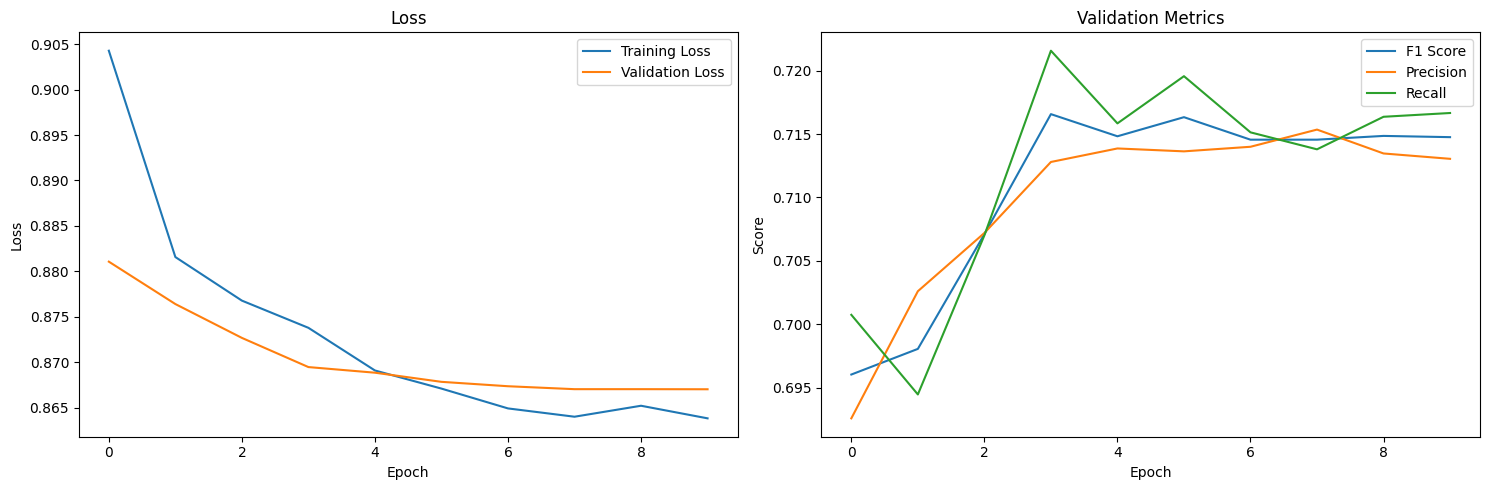

Evaluating on test set: 100%|██████████| 235/235 [00:17<00:00, 13.32it/s]
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Threshold analysis on test set:
Threshold 0.30 - F1: 0.2307, Precision: 0.1499, Recall: 0.5000
Threshold 0.40 - F1: 0.2307, Precision: 0.1499, Recall: 0.5000
Threshold 0.55 - F1: 0.7068, Precision: 0.7020, Recall: 0.7140
Threshold 0.50 - F1: 0.2307, Precision: 0.1499, Recall: 0.5000
Threshold 0.60 - F1: 0.7119, Precision: 0.7098, Recall: 0.7143
Threshold 0.70 - F1: 0.7025, Precision: 0.7130, Recall: 0.6954

Best threshold on test set: 0.6000
Best macro F1 on test set: 0.7119

Final Test Results (using validation threshold 0.5500):
Macro F1: 0.7068
Precision: 0.7020
Recall: 0.7140


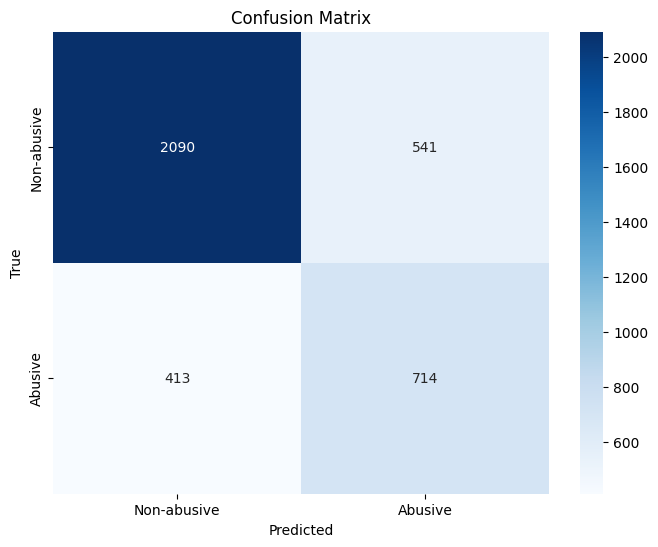

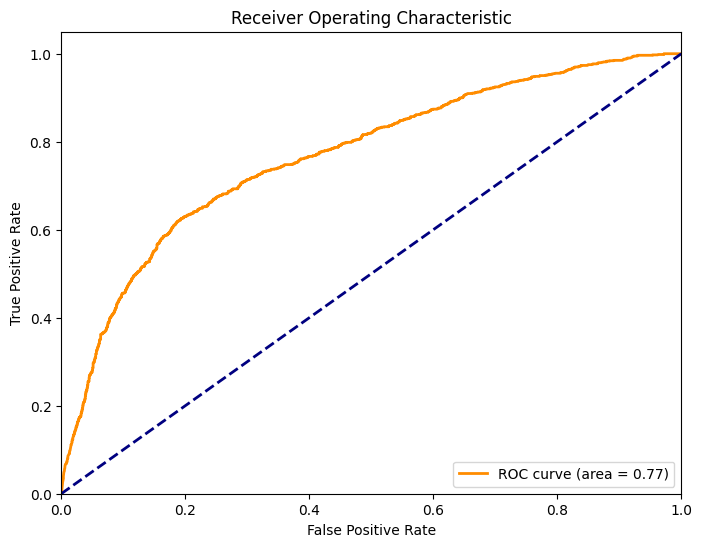

In [34]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, precision_score, recall_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Load the test dataset
test_data = pd.read_csv('/kaggle/working/fine_tuned_test.csv')

# Print test dataset info
print(f"Test dataset size: {len(test_data)}")
print("Class distribution:")
print(test_data['label'].value_counts(normalize=True))

# Create test dataset
test_dataset = GenderedAbuseDataset(
    texts=test_data['cleaned_text'].values,
    labels=test_data['label'].values,
    tokenizer=tokenizer,
    max_length=128
)

# Create test DataLoader
test_loader = DataLoader(
    test_dataset,
    batch_size=16,
    shuffle=False
)

# Load the best model 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('best_model_fine_tuned.pt')
model.load_state_dict(checkpoint['model_state_dict'])
best_threshold = checkpoint['threshold']
model.to(device)

print(f"Loaded best model from epoch {checkpoint['epoch']+1} with Macro F1: {checkpoint['macro_f1']:.4f}")
print(f"Using optimal threshold: {best_threshold:.4f}")

# Plot the training history
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['val_f1'], label='F1 Score')
plt.plot(history['val_precision'], label='Precision')
plt.plot(history['val_recall'], label='Recall')
plt.title('Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.savefig('training_history.png')  # Save the plot to file
plt.show()

# Evaluate on test set
model.eval()
test_preds = []
test_labels = []

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Evaluating on test set"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label']
        
        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits if hasattr(outputs, 'logits') else outputs
        
        if logits.dim() > 1 and logits.shape[1] > 1:
            logits = logits.squeeze(-1)
        
        preds = torch.sigmoid(logits).cpu().numpy()
        test_preds.extend(preds.flatten())
        test_labels.extend(labels.numpy())

# Try different thresholds to see performance
print("\nThreshold analysis on test set:")
thresholds = [0.3, 0.4, best_threshold, 0.5, 0.6, 0.7]
results = []

for threshold in thresholds:
    test_preds_binary = np.array(test_preds) >= threshold
    test_true = np.array(test_labels)
    
    test_f1 = f1_score(test_true, test_preds_binary, average='macro')
    test_precision = precision_score(test_true, test_preds_binary, average='macro')
    test_recall = recall_score(test_true, test_preds_binary, average='macro')
    
    results.append({
        'threshold': threshold,
        'f1': test_f1,
        'precision': test_precision, 
        'recall': test_recall
    })
    
    print(f"Threshold {threshold:.2f} - F1: {test_f1:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}")

# Find best threshold on test set
test_thresholds = np.arange(0.3, 0.7, 0.05)
test_f1_scores = []

for threshold in test_thresholds:
    test_preds_binary = np.array(test_preds) >= threshold
    test_f1 = f1_score(np.array(test_labels), test_preds_binary, average='macro')
    test_f1_scores.append(test_f1)

best_test_threshold = test_thresholds[np.argmax(test_f1_scores)]
best_test_f1 = max(test_f1_scores)

print(f"\nBest threshold on test set: {best_test_threshold:.4f}")
print(f"Best macro F1 on test set: {best_test_f1:.4f}")

# Final evaluation using the optimal threshold from validation
test_preds_binary = np.array(test_preds) >= best_threshold
test_true = np.array(test_labels)

test_f1 = f1_score(test_true, test_preds_binary, average='macro')
test_precision = precision_score(test_true, test_preds_binary, average='macro')
test_recall = recall_score(test_true, test_preds_binary, average='macro')

print(f"\nFinal Test Results (using validation threshold {best_threshold:.4f}):")
print(f"Macro F1: {test_f1:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")

# Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_true, test_preds_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-abusive', 'Abusive'],  # Adjust these labels based on your dataset
            yticklabels=['Non-abusive', 'Abusive'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('confusion_matrix.png')
plt.show()

# Plot ROC curve
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(test_labels, test_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('roc_curve.png')
plt.show()